In [1]:
import pandas as pd, psycopg2
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def query_database(connection, sql, *args, **kwargs):
    if connection.get_transaction_status() == 3:
        connection.reset()
    with connection.cursor() as cursor:
        cursor.execute(sql, *args, **kwargs)
        rows = cursor.fetchall()
        columns = [d[0] for d in cursor.description]
    df = pd.DataFrame(rows, columns=columns)
    return df

In [3]:
connection = psycopg2.connect('postgres://fga@localhost/fga')

In [6]:
sql = '''
with users_ as (
    select
        user_id,
        client,
        created_at
        
    from (
        select
            "UserID" as user_id,
            "DeviceOS" as client,
            "CreatedAt"::timestamp as created_at,
            row_number() over (partition by "UserID" order by "CreatedAt")
            
        from devices
    ) u
    
    where row_number = 1

), events_ as (
    select
        "createdAt"::timestamp as ts,
        "currentUser" as user_id,
        "action" as action
        
    from events

), quiz_events as (
    select
        ts,
        user_id
        
    from events_
    
    where action = 'START_QUIZ'

), n_quizzes_submitted as (
    select
        ts::date as date,
        client,
        count(1) as n_quizzes_submitted
        
    from quiz_events 
        join users_ using (user_id)
        
    group by 1, 2
    
), n_active_users as (
    select
        ts::date as date,
        client,
        count(distinct user_id) as n_active_users
        
    from events_ join users_ using (user_id)
    
    group by 1, 2
    
), results as (
    select
        date, 
        client,
        n_quizzes_submitted,
        n_active_users,
        n_quizzes_submitted::float / n_active_users as mean_quizzes_submitted
        
    from n_active_users
        join n_quizzes_submitted
        
    using (date, client)
    
    order by 1, 2

)

select * from results
'''

df = query_database(connection, sql)
df.head()

,date,client,n_quizzes_submitted,n_active_users,mean_quizzes_submitted
0,2019-10-14,Android,589,461,1.277657
1,2019-10-14,iOS,387,337,1.148368
2,2019-10-15,Android,509,408,1.247549
3,2019-10-15,iOS,376,334,1.125749
4,2019-10-16,Android,334,275,1.214545


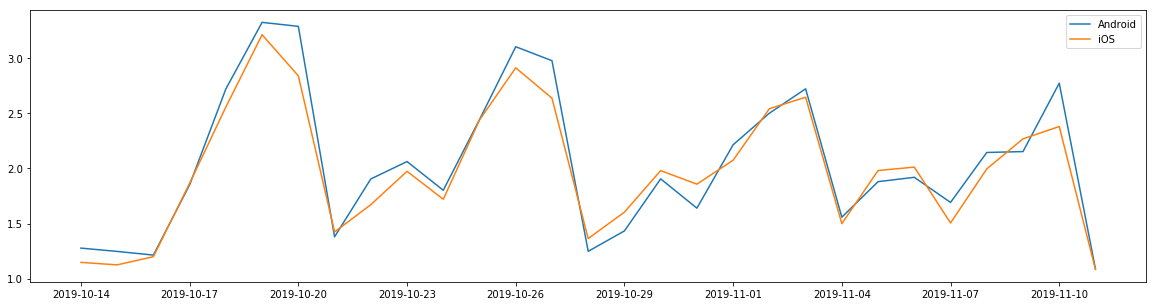

In [7]:
fig, ax = plt.subplots(figsize=(20, 5))
for client, df_ in df.groupby('client'):
    ax.plot(df_['date'], df_['mean_quizzes_submitted'], label=client)
ax.legend()